## Simulate and fit DCE-MRI

In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('..')
import dce_fit, relaxivity, signal_models, water_ex_models, aifs, pk_models
%load_ext autoreload
%autoreload 2

### Simulate and fit time-concentration data

Wall time: 45 ms
parameter: value (ground truth)
vp: 0.020439 (0.020000)
ps: 0.050111 (0.050000)
ve: 0.194727 (0.200000)
fp: 49.002331 (50.000000)
delay: 5.099115 (5.000000)


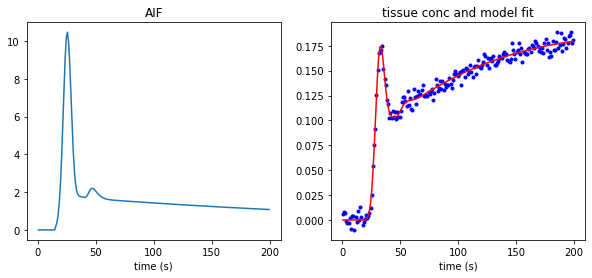

In [170]:
# define experiment timepoints
dt = 1.
t = np.arange(0,200)*dt + dt/2

# define ground-truth AIF, pharmacokinetic model, parameters and noise level
aif = aifs.parker(hct=0.42, t_start=15.)
pk_pars_ground_truth = {'vp': 0.02, 'ps': 5e-2, 've': 0.2, 'fp': 50, 'delay': 5}
pk_model_ground_truth = pk_models.tcxm(t, aif, fixed_delay=None)
noise = 0.005

# generate "measured" concentration then add noise
C_t, _c_cp, _c_e = pk_model_ground_truth.conc(**pk_pars_ground_truth)
C_t += np.random.normal(loc = 0., scale = noise, size = c_t.shape)

# define AIF, pharmacokinetic model and starting parameters used for fitting.
pk_model = pk_models.tcxm(t, aif, fixed_delay=None) # use ground-truth AIF to fit data, i.e. assume AIF is known accurately
pk_pars_0 = [{'vp': 0.005, 'ps': 1e-4, 've': 0.5, 'fp': 5, 'delay': 0}, # optionally specify multiple sets of starting values to find global minimum 
             {'vp': 0.1, 'ps': 1e-4, 've': 0.02, 'fp': 50, 'delay': 0}
            ]
%time pk_pars_fit, C_t_fit = dce_fit.conc_to_pkp(C_t, pk_model, pk_pars_0=pk_pars_0)

print("parameter: value (ground truth)")
[ print(f"{key}: {val:.6f} ({pk_pars_ground_truth[key]:.6f})") for key, val in pk_pars_fit.items() ]

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(t, aif.c_ap(t));
ax[0].set_xlabel('time (s)');
ax[0].set_title('AIF');
ax[1].plot(t, C_t, 'b.', t, C_t_fit, 'r-');
ax[1].set_xlabel('time (s)');
ax[1].set_title('tissue conc and model fit');

### Simulate and fit in signal space

Wall time: 45.3 ms
parameter: value (ground truth)
vp: 0.020012 (0.020000)
ps: 0.048285 (0.050000)
ve: 0.209282 (0.200000)
fp: 10.447445 (10.000000)
delay: 3.180471 (3.000000)


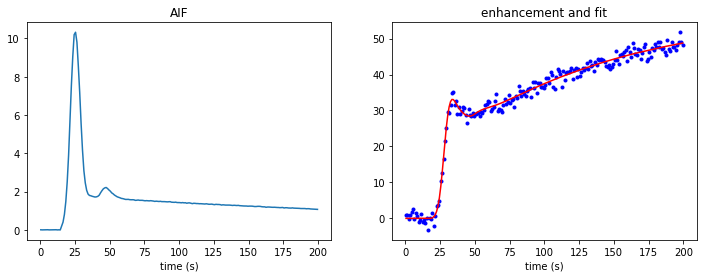

In [4]:
# define ground-truth (gt) properties
dt_gt = 0.1 # gt temporal resolution
aif = aifs.parker(hct=0.42, t_start=15.)
pk_pars_gt = {'vp': 0.02, 'ps': 5e-2, 've': 0.2, 'fp': 10, 'delay': 3}
R10_tissue, R10_aif = 1./0.8, 1./1.7
hct = 0.42

# define acquisition properties
k_tissue, k_aif = 1.0, 1.0 # relative B1+ error
tr, fa, te = 4e-3, 15, 1.5e-3
dt = 1 # experimental temporal resolution
t = np.arange(0,round(200/dt))*dt + dt/2 # measured time points
noise = 1.5

# define ground-truth (gt) models for relaxivity, signal and pharmacokinetics
pk_model_gt = pk_models.tcxm(t, aif, dt_interp_request=dt_gt, fixed_delay=None)
c_to_r_model_gt = relaxivity.c_to_r_linear(r1=5.0, r2=7.1)
water_ex_model_gt = water_ex_models.fxl()
signal_model_gt = signal_models.spgr(tr, fa, te)

# now generate the measured AIF 
c_ap = aif.c_ap(t)
enh_aif = dce_fit.conc_to_enh(c_ap*(1-hct), k_aif, R10_aif, c_to_r_model_gt, signal_model_gt)
enh_aif += np.random.normal(loc = 0., scale = noise, size = enh_aif.shape)
c_ap_meas = dce_fit.enh_to_conc(enh_aif, k_aif, R10_aif, c_to_r_model_gt, signal_model_gt)/(1-hct)
aif_meas = aifs.patient_specific(t, c_ap_meas)

# generate the measured tissue enhancement
enh = dce_fit.pkp_to_enh(pk_pars_gt, hct, k_tissue, R10_tissue, R10_aif, pk_model_gt, c_to_r_model_gt, water_ex_model_gt, signal_model_gt)
enh += np.random.normal(loc = 0., scale = noise, size = enh.shape)

# define models used for fitting
pk_model_fit = pk_models.tcxm(t, aif_meas, dt_interp_request=dt/3, fixed_delay=None)
c_to_r_model_fit = c_to_r_model_gt # use same model as for ground truth
water_ex_model_fit = water_ex_model_gt # use same model as for ground truth
signal_model_fit = signal_model_gt # use same model as for ground truth
k_tissue_fit = k_tissue # assume flip angle error is known accurately
pk_pars_0 = [{'vp': 0.005, 'ps': 1e-4, 've': 0.5, 'fp': 5, 'delay': 0}, # optionally specify multiple sets of starting values to find global minimum 
             #{'vp': 0.1, 'ps': 1e-4, 've': 0.02, 'fp': 50, 'delay': 0}
            ]

# fit the enhancement curve
%time pk_pars_fit, enh_fit = dce_fit.enh_to_pkp(enh, hct, k_tissue_fit, R10_tissue, R10_aif, pk_model_fit, c_to_r_model_fit, water_ex_model_fit, signal_model_fit, pk_pars_0=pk_pars_0)

print("parameter: value (ground truth)")
[ print(f"{key}: {val:.6f} ({pk_pars_gt[key]:.6f})") for key, val in pk_pars_fit.items() ]

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(t, c_ap_meas);
ax[0].set_xlabel('time (s)');
ax[0].set_title('AIF');
ax[1].plot(t, enh, 'b.', t, enh_fit, 'r-')
ax[1].set_xlabel('time (s)');
ax[1].set_title('enhancement and fit');